# Packages and Imports

## Install Required Packages

In [1]:
!pip install tqdm
!pip install opencv-python
!pip install scikit-image
!pip install torch 
!pip install matplotlib
!pip install torchvision
!pip install numpy
!git clone https://github.com/facebookresearch/dino
import sys
sys.path.append('dino')
%load_ext autoreload
%autoreload 2

fatal: destination path 'dino' already exists and is not an empty directory.


## Imports

In [54]:
from tqdm import tqdm 
import cv2
import torch
import torch.nn as nn
from PIL import Image
import torchvision
from torchvision import transforms as pth_transforms
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# import DINO-ViT related files
import vision_transformer as vits

In [37]:
# set to GPU if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [68]:
args = {"arch": "vit_small",
 "patch_size": 8,
 "out_dim": 65536,
 "norm_last_layer": False,
 "warmup_teacher_temp": 0.04,
 "teacher_temp": 0.07,
 "warmup_teacher_temp_epochs": 30,
 "use_fp16": False,
 "weight_decay": 0.04,
 "weight_decay_end": 0.4,
 "clip_grad": 0,
 "batch_size_per_gpu": 64,
 "epochs": 800,
 "freeze_last_layer": 1,
 "lr": 0.0005,
 "warmup_epochs": 10,
 "min_lr": 1e-05,
 "global_crops_scale": [0.25,
 1.0],
 "local_crops_scale": [0.05,
 0.25],
 "local_crops_number": 10,
 "seed": 0,
 "num_workers": 10,
 "world_size": 16,
 "ngpus": 8,
 "nodes": 2,
 "optimizer": "adamw",
 "momentum_teacher": 0.996,
 "use_bn_in_head": False,
 "drop_path_rate": 0.1,
 "image_path": "./test_img/airbud.jpeg",
 "threshold": None,
 "image_size": (480, 480),
 "output_dir": "./"
}


# DINO ViT Utility Functions

## Load Pretrained Models

In [75]:
# create function to load pretrained model
def load_pretrained_ViT(args):

    # initialize models
    student = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
    teacher = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
    
    # fetch pretrained models
    url = None
    if args['arch'] == "vit_small" and args['patch_size'] == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain_full_checkpoint.pth"
    elif args['arch'] == "vit_small" and args['patch_size'] == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain_full_checkpoint.pth"  # model used for visualizations in our paper
    elif args['arch'] == "vit_base" and args['patch_size'] == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain_full_checkpoint.pth"
    elif args['arch'] == "vit_base" and args['patch_size'] == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain_full_checkpoint.pth"
        
    state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
    
    state_dict_teacher = state_dict['teacher']
    # remove `module.` prefix
    state_dict_teacher = {k.replace("module.", ""): v for k, v in state_dict_teacher.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict_teacher = {k.replace("backbone.", ""): v for k, v in state_dict_teacher.items()}
    
    msg = teacher.load_state_dict(state_dict_teacher, strict=False)
    print('Pretrained weights found and loaded with msg: {}'.format(msg))
    
    state_dict_student = state_dict['student']
    # remove `module.` prefix
    state_dict_student = {k.replace("module.", ""): v for k, v in state_dict_student.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict_student = {k.replace("backbone.", ""): v for k, v in state_dict_student.items()}
     
    msg = student.load_state_dict(state_dict_student, strict=False)
    print('Pretrained weights found and loaded with msg: {}'.format(msg))
    
    # test this by running the eval thing
    return student, teacher

# finetune ViT
    # load pretrained ImageNet model
    # train pretrained model (for one epoch)

## Visualize Attention Maps

In [77]:
def visualize_attention(model, args, img):

    for p in model.parameters():
        p.requires_grad = False

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    if args['threshold'] is not None:
        # we keep only a certain percentage of the mass
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - args['threshold'])
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        # interpolate
        th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    os.makedirs(args['output_dir'], exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args['output_dir'], "img.png"))
    for j in range(nh):
        fname = os.path.join(args['output_dir'], "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        print(f"{fname} saved.")
        plt.imshow(attentions[j])
        plt.show()

    if args['threshold'] is not None:
        image = skimage.io.imread(os.path.join(args['output_dir'], "img.png"))
        for j in range(nh):
            display_instances(image, th_attn[j], fname=os.path.join(args['output_dir'], "mask_th" + str(args['threshold']) + "_head" + str(j) +".png"), blur=False)
 

# Testing

Pretrained weights found and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.projection_head.0.weight', 'head.projection_head.0.bias', 'head.projection_head.2.weight', 'head.projection_head.2.bias', 'head.projection_head.4.weight', 'head.projection_head.4.bias', 'head.prototypes.weight'])
Pretrained weights found and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.projection_head.0.weight', 'head.projection_head.0.bias', 'head.projection_head.2.weight', 'head.projection_head.2.bias', 'head.projection_head.4.weight', 'head.projection_head.4.bias', 'head.prototypes.weight'])
./attn-head0.png saved.


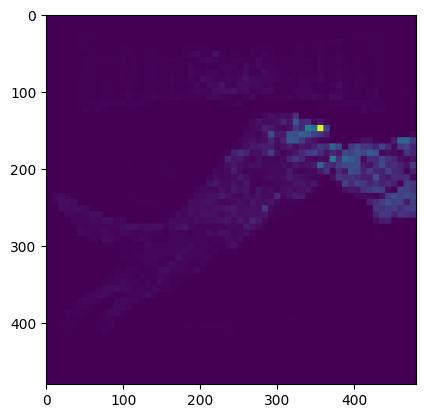

./attn-head1.png saved.


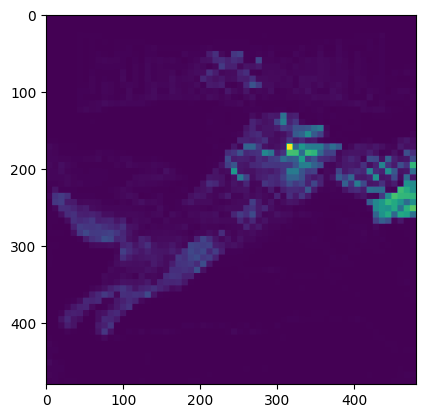

./attn-head2.png saved.


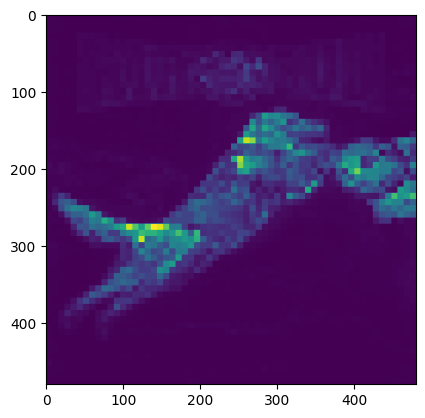

./attn-head3.png saved.


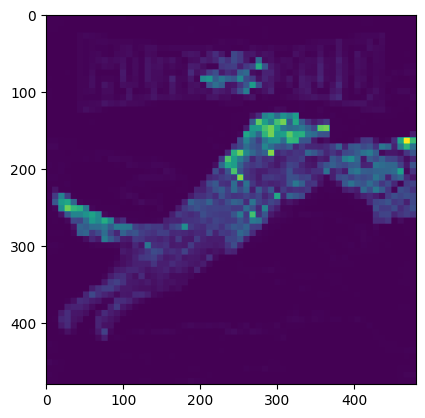

./attn-head4.png saved.


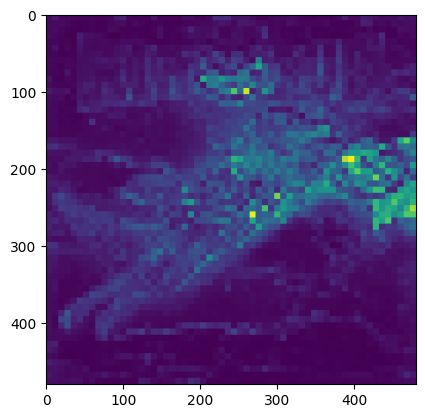

./attn-head5.png saved.


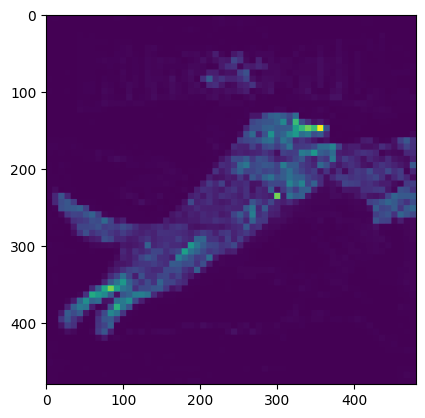

In [76]:
student, teacher = load_pretrained_ViT(args)

# load image
image_path = "./test_img/airbud.jpeg"
with open(image_path, 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')
transform = pth_transforms.Compose([
    pth_transforms.Resize(args['image_size']),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args['patch_size'], img.shape[2] - img.shape[2] % args['patch_size']
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // args['patch_size']
h_featmap = img.shape[-1] // args['patch_size']

visualize_attention(teacher, args, img)


In [71]:
# figure out how to fine-tune certain weights/layers

In [ ]:
# output to DNN

In [ ]:
# visualize self-attention

# TODO
- ViT uses square images - how do we include irregularly sized posters?
- resizing layer so that ViT output can be used as input to DNN
    - what size is the input to the DNN
        - DNN takes 2 inputs from movie posters (global pooled)
            - Will global pooling help with ViT layers?
    - what size is the output of the pretrained ViT
        - 6 attention heads
        - 3600 attentions for dinovit8-small (60x60)
            - determined by imagesize/patchsize (480/8 = 60)
    - what's the best way to go about this?
- fine-tune pretrained ViT models for image posters
    - goal is to get self-attention to see poster logos